In [281]:
using LinearAlgebra
using Plots
using Distributions
using LaTeXStrings
using Random
using TSVD
using TensorOperations
include("../../sesh3/src/functions.jl")
include("../../sesh2/src/functions.jl")

rank_7_CPD

# Popovic Milutin: Solution to Assingment 4

# Exercise 1

In [321]:
function hosvd(C, r)
    S0 = copy(C)
    d = length(size(C))
    n = size(C)
    V = []
    singular_values = []
    errors = []
    for k=1:d
        B = reshape(S0, (prod([[r_i for  r_i in r[1:(k-1)]]..., [i_k for i_k in n[(k+1):end]]...])..., n[k]))
        U_hat, Sig_hat, V_hat = tsvd(convert(Matrix{Float64}, B), r[k])
        B_hat = U_hat * Diagonal(Sig_hat) * transpose(V_hat)
        W_hat = B * V_hat
        S0 = reshape(W_hat , ([r_i for r_i in r[1:k]]..., [n_k for n_k in n[k+1:end]]...))
        
        append!(V, [V_hat])
        append!(singular_values, [Sig_hat])
        C_hat = tucker_eval(S0, V)
        append!(errors, norm(C_hat - C)/norm(C))
    end
    return V, S0, singular_values, errors
end


function tucker_eval(S, V)
    d = length(V)+1
    A = copy(S)
    for (k, V_k) in enumerate(reverse(V))
        A = mode_k_dot(A, V_k, d-k)
    end
    return A
end

tucker_eval (generic function with 1 method)

# Exercise 2

In [121]:
d = 4;
n = [20+k for k=1:d];
r = [2*k for k=1:d];
V = [rand(Uniform(-1, 1), n[k], r[k]) for k=1:d];
S = rand(Uniform(-1, 1), r...);
A = tucker_eval(S, V);
V, S, singular_values, errors = hosvd(A, r);

# Exercise 3

In [336]:
function f(x)
    s = 0
    for (k, xk) in enumerate(x)
        s = s .+ (xk.^2 / (8^(k-1)))
    end
    return (1 .+ s).^(-1)
end

function g(x)
    s1 = 0
    s2 = 0
    for (k, xk) in enumerate(x)
        s1 = s1 .+ (xk.^2 / (8^(k-1)))
        s2 = s2 .+ (4 * pi * xk)/(4^(k-1))
    end
    return sqrt.(s1) .* (1 .+ 1/2 * cos.(s2))
end

function unfold(A, k)
    B = permutedims(A, vcat(k, setdiff(1:length(size(A)), k)))
    d = size(B, 1)
    return reshape(B, (d, div(length(B),d)))
end

function sing_unfold(C, d)
    vals = []
    for k=1:d
        U, S, V = svd(unfold(C, k))
        append!(vals, [S])
    end
    return vals
end

t(n) = [(2*(i-1)/(n-1) - 1) for i in 1:n]

t (generic function with 1 method)

In [656]:
d = 4; n = 51;
A = [f([t1, t2, t3, t4]) for t1 in t(n), t2 in t(n), t3 in t(n), t4 in t(n)];
B = [g([t1, t2, t3, t4]) for t1 in t(n), t2 in t(n), t3 in t(n), t4 in t(n)];

## Exercise 3a

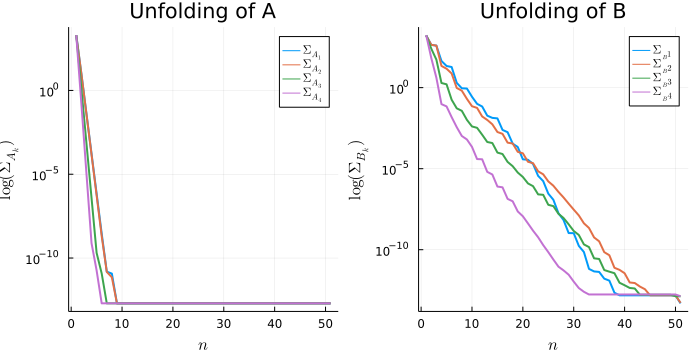

In [383]:
sing_a = sing_unfold(A, d);
sing_b = sing_unfold(B, d);
p = plot(layout=2, size=[700, 350])
for k=1:d
    plot!(p[1],
        sing_a[k],
        ylabel=L"$\log(\Sigma_{A_k})$",
        label=L"$\Sigma_{A_%$k}$",
        xlabel=L"n",
        lw = 2,
        yaxis=:log,
        title="Unfolding of A")
    plot!(p[2],
        sing_b[k],
        ylabel=L"$\log(\Sigma_{B_k})$",
        label=L"$\Sigma_{_B%$k}$",
        xlabel=L"n",
        lw = 2,
        yaxis=:log,
        title="Unfolding of B")
end
plot(p)

In [657]:
eps_j = [1/(10^(j*2)) for j=1:5]
function rank_approx(C, eps_j=eps_j)
    d = length(size(C))
    eps_jk = []; r_jk = []; singular_vec = []
    for k=1:d
        C_k = unfold(C, k)
        for (j, e_j) in enumerate(eps_j)
            for r=1:rank(C_k)
                U_hat, S_hat, V_hat = tsvd(C_k, r)
                C_k_hat = U_hat * Diagonal(S_hat) * transpose(V_hat)
                if norm(C_k_hat-C_k)/norm(C_k) <= e_j
                    append!(eps_jk, norm(C_k_hat-C_k)/norm(C_k))
                    append!(r_jk, r)
                    break
                end
            end
        end
    end
        return reshape(r_jk, (length(eps_j), d)), reshape(eps_jk, (length(eps_j), d))
end
r_jk_a, eps_jk_a = rank_approx(A)
r_jk_b, eps_jk_b = rank_approx(B)


(Any[6 4 3 2; 10 9 6 3; … ; 22 22 17 12; 25 28 24 16], Any[0.0013630857628283304 0.009518329263607794 0.0014509541080803049 0.0023517835675429264; 7.159528543404029e-5 5.3592722281017756e-5 3.786849235801887e-5 6.886783883231526e-5; … ; 2.3048992932560663e-9 4.865446890113614e-9 9.055790097998212e-9 4.494606310730708e-9; 7.057122859935684e-11 4.462051964776192e-11 4.58120456032028e-11 9.80285039910442e-11])

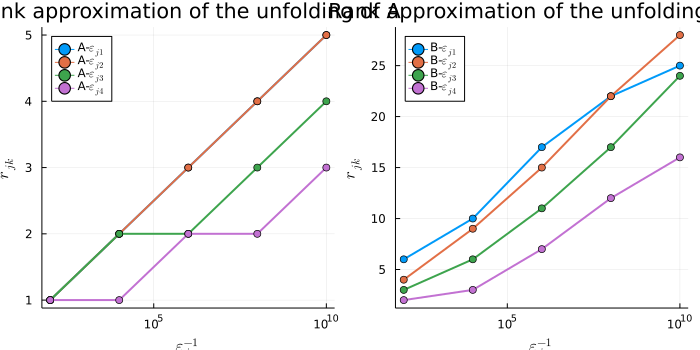

In [658]:
p = plot(layout=2, size=[700, 350])
for k=1:d
    plot!(p[1],
        1 ./ eps_j,
        r_jk_a[:, k],
        ylabel=L"$r_{jk}$",
        label=L"A-$\varepsilon_{j%$k}$",
        xlabel=L"\varepsilon_{j}^{-1}",
        lw = 2,
        markershape=:circle,
        xaxis=:log10,
        legend=:topleft,
        title="Rank approximation of the unfolding of A")
    plot!(p[2],
        1 ./ eps_j,
        r_jk_b[:, k],
        ylabel=L"$r_{jk}$",
        label=L"B-$\varepsilon_{j%$k}$",
        xlabel=L"\varepsilon_{j}^{-1}",
        lw = 2,
        markershape=:circle,
        xaxis=:log10,
        legend=:topleft,
        title="Rank approximation of the unfolding of B")
end
plot(p)


# Exercise 3b

# Exercise 4, 5

In [305]:
function ttmps_eval(U, n)
    A = U[1]
    for U_k=U[2:end]
        A = contract(A, U_k)
    end
    return reshape(A, n...)
end

function tt_svd(A, n, r, d)
    r_0 = 1
    r_new = [r_0, r...]
    S_0_hat = copy(A)
    S0s = []
    C = []; singular_val = []; errors = []
    for k=2:d
        B_k = reshape(S_0_hat, (r_new[k-1] * n[k-1], prod([n[i] for i=k:d])))
        U_hat, Sig_hat, V_hat = tsvd(convert(Matrix{Float64}, B_k), r_new[k])
        C_k = reshape(U_hat, (r_new[k-1], n[k-1], r_new[k]))
        W_k_hat = Diagonal(Sig_hat) * transpose(V_hat)
        S_0_hat = reshape(W_k_hat, (r_new[k], [n[i] for i=k:d]...))
        
        append!(C, [C_k])
        append!(singular_val, [Sig_hat])
        A_hat = ttmps_eval([C..., S_0_hat], n )
        append!(errors, norm(A_hat - A)/norm(A))
    end
    append!(C, [S_0_hat])
    return C, singular_val, errors
end

tt_svd (generic function with 1 method)

# Exercise 6

In [306]:
d = 4;
n = [20+k for k=1:d];
r = [[2*k for k=1:(d-1)]..., 1];
V = [rand(Uniform(-1, 1), n[k], r[k]) for k=1:d];
S = rand(Uniform(-1, 1), r...);
A = tucker_eval(S, V);
C, singular_val, errors= tt_svd(A, n, r, d);

# Exercise 7